Copyright (c) 2025 Graphcore Ltd. All rights reserved.

# QAT

Quantisation Aware Training results

In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import torch
from torch import tensor, Tensor
from typing import Iterable, Any

import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

import data_utils as D
import weight_formats.experiments as E
import plot_utils

plot_utils.configure()

Recommend (Ubuntu):
  sudo apt-get install cm-super dvipng fonts-cmu texlive-latex-extra


In [2]:
# Matches Experiments.ipynb:SELECTED_FORMATS
VARIABLE_LENGTH_FORMATS = [
    dict(label="Tensor RMS + Compression", color=plot_utils.PALETTE[0]),
    dict(label="Tensor RMS + Sparsity", color=plot_utils.PALETTE[1]),
    dict(label="Block Absmax", color=plot_utils.PALETTE[2]),
    dict(label="Channel Absmax", color=plot_utils.PALETTE[3]),
]
FIXED_LENGTH_FORMATS = [
    dict(label="Tensor Absmax", color=plot_utils.PALETTE[4]),
    dict(label="Tensor RMS", color=plot_utils.PALETTE[5]),
]
def fmt_name(fmt: E.AttrDict) -> str:
    s = [{(None, None): "Tensor", (1, None): "Channel"}.get(tuple(fmt.block_shape), "Block") + f" {fmt.scaling.capitalize()}"]
    if fmt.compressor:
        s.append("Compression")
    if fmt.sparse_ratio:
        s.append("Sparsity")
    return " + ".join(s).replace("Rms", "RMS")


# According to 0613-Downstream.ipynb, from counting validation_docs() in oe_task (task limit according to experiments.qat).
downstream_instance_counts = {
    'arc_challenge:mc': 299,
    'arc_easy:mc': 570,
    'boolq': 3270,
    'csqa:mc': 1221,
    'hellaswag': 1000,
    'openbookqa:mc': 500,
    'piqa': 1838,
    'socialiqa:mc': 1954,
    'winogrande': 1267}

def downstream_mean_stats(d: pd.DataFrame) -> dict[str, pd.Series]:
    baseline = d[d.tag == "baseline"].downstream.iloc[0]

    def _ratio(s: dict[str, float]) -> float:
        return tensor([
            torch.tensor(s[task] / baseline_accuracy).clip(0, 1)
            for task, baseline_accuracy in baseline.items()
        ]).mean().item()

    def _ratio_stderr(s: dict[str, float]) -> float:
        var = 0
        for task in baseline:
            p = torch.tensor(s[task] / baseline[task]).clip(0, 1)
            var += p.mul(1 - p).div(downstream_instance_counts[task])
        return var.sqrt().div(len(baseline)).item()

    return dict(
        downstream_mean_ratio=d.downstream.apply(_ratio),
        downstream_mean_ratio_stderr=d.downstream.apply(_ratio_stderr),
    )


def load_run(run: E.AttrDict) -> dict[str, Any]:
    # Config
    d = dict(
        id=run.id,
        tag=run.config.tag,
        model=run.config.model.split("/")[-1],
    )
    if run.config.test.type == "qat":
        # Config (QAT)
        d.update(
            steps=run.config.train.steps,
            lr=run.config.opt.lr,
            fmt=fmt_name(run.config.test.fmt),
            element_bits=run.config.test.fmt.element_bits,
        )
    else:
        d.update(steps=None, fmt=None, element_bits=None)
    if "train" in run.summary:
        # Training log
        d.update(
            step=torch.arange(len(run.summary.train.loss)).mul(run.config.train.log_interval).tolist(),
            step_loss=run.summary.train.loss,
            step_valid_kl=run.summary.train.valid_kl_div,
        )
    # Summary
    d.update(
        bits_per_param=run.summary.get("bits_per_param"),
        valid_kl=run.summary.get("valid_kl_div"),
        downstream={k: v.primary_score for k, v in sorted(run.summary.get("downstream", {}).items())},
    )
    return d


df = pd.DataFrame.from_records([
    load_run(run) for run in E.runs("20250708-qat-main", progress=True)
])
df = df[df.tag.isin(["baseline", "direct-cast", "qat-v2"])]
df = df[df.downstream.apply(bool)]
df = (df.groupby("model")
    .apply(lambda g: g.assign(**downstream_mean_stats(g)), include_groups=False)
    .reset_index().drop(columns="level_1")
)
df.head()

query: 204it [00:00, 333.00it/s]


,model,id,tag,steps,fmt,element_bits,step,step_loss,step_valid_kl,bits_per_param,valid_kl,downstream,lr,downstream_mean_ratio,downstream_mean_ratio_stderr
0,Llama-3.1-8B,20250708-qat-main/zev9ClTfSs,baseline,NaN,None,NaN,[0.0],[None],[0.00091089529],16.000000,0.001009,"{'arc_challenge:mc': 0.79598662, 'arc_easy:mc'...",NaN,1.000000,0.000000
1,Llama-3.1-8B,20250708-qat-main/8SM5Idhorn,direct-cast,0.0,Tensor RMS + Compression,3.0,[0.0],[None],[0.20535371],3.000824,0.205200,"{'arc_challenge:mc': 0.71571906, 'arc_easy:mc'...",0.0,0.928542,0.003224
2,Llama-3.1-8B,20250708-qat-main/aX4kDBpHCX,direct-cast,0.0,Tensor RMS + Sparsity,3.0,[0.0],[None],[0.50339442],3.047309,0.503325,"{'arc_challenge:mc': 0.47157191, 'arc_easy:mc'...",0.0,0.798715,0.004953
3,Llama-3.1-8B,20250708-qat-main/K0kOcZlPEJ,direct-cast,0.0,Block Absmax,3.0,[0.0],[None],[1.260321],3.250426,1.263831,"{'arc_challenge:mc': 0.24414716, 'arc_easy:mc'...",0.0,0.544516,0.005408
4,Llama-3.1-8B,20250708-qat-main/aOtkl4rKPY,direct-cast,0.0,Channel Absmax,3.0,[0.0],[None],[1.0748091],3.003688,1.074679,"{'arc_challenge:mc': 0.27090301, 'arc_easy:mc'...",0.0,0.608424,0.005356


### `xpq_downstream_qat`

remote: Updating references: 100% (1/1)           


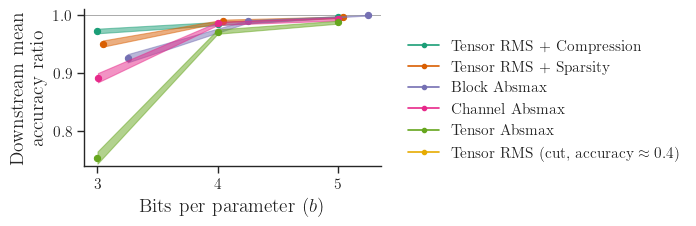

In [52]:
d = df[(df.model == "Llama-3.1-8B") & (df.tag == "qat-v2")].sort_values("bits_per_param")
_, ax = plt.subplots(figsize=(7, 2.5))

for args in VARIABLE_LENGTH_FORMATS + FIXED_LENGTH_FORMATS:
    g = d[d.fmt == args["label"]]
    ax.fill_between(g.bits_per_param, g.downstream_mean_ratio - 2 * g.downstream_mean_ratio_stderr,
                    g.downstream_mean_ratio + 2 * g.downstream_mean_ratio_stderr, **args, alpha=.5)
    ax.scatter(g.bits_per_param, g.downstream_mean_ratio, s=20)

ax.set_ylim((0.74, 1.01))
ax.set_ylabel("Downstream mean\naccuracy ratio")
ax.set_xlabel("Bits per parameter ($b$)")
ax.axhline(1, color="#888", zorder=-1, lw=0.5)
ax.set_xticks([3, 4, 5])
legend = [
    dict(**d, marker="o") for d in VARIABLE_LENGTH_FORMATS + FIXED_LENGTH_FORMATS
]
legend[-1]["label"] += r" (cut, accuracy $\approx 0.4$)"
plot_utils.set_figure_legend(ax.figure, build=legend)
plot_utils.tidy(ax.figure)
plot_utils.save("xpq_downstream_qat")

### `xpq_compare_downstream_qat`

remote: Updating references: 100% (1/1)           


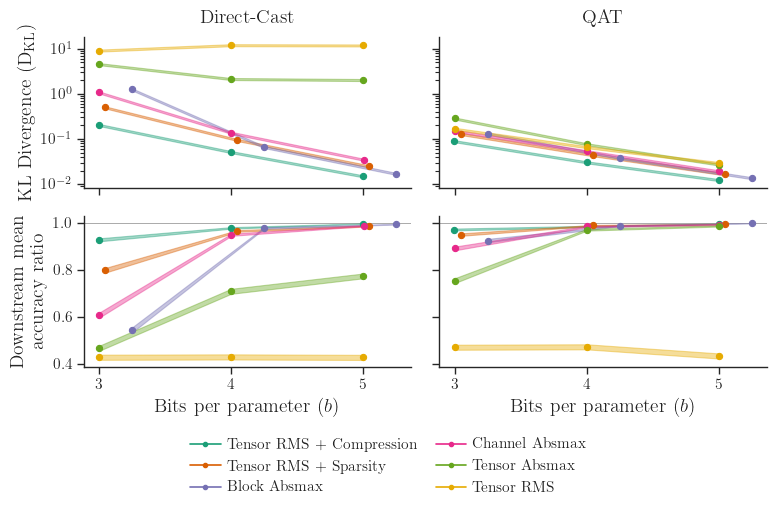

In [11]:
figw, figh = matplotlib.rcParams["figure.figsize"]
_, axs = plt.subplots(2, 2, figsize=(figw, 1.5*figh), sharey="row", sharex=True)
d = df[(df.model == "Llama-3.1-8B")].sort_values("bits_per_param")

for y, axr in zip(["valid_kl", "downstream_mean_ratio"], axs):
    for tag, ax in zip(["direct-cast", "qat-v2"], axr):
        for args in VARIABLE_LENGTH_FORMATS + FIXED_LENGTH_FORMATS:
            g = d[(d.tag == tag) & (d.fmt == args["label"])]
            if y == "valid_kl":
                err = g.valid_kl * 0.026  # estimate from the "typical ratio" (Experiments.ipynb)
            elif y == "downstream_mean_ratio":
                err = g.downstream_mean_ratio_stderr
            ax.fill_between(g.bits_per_param, g[y] - 2*err, g[y] + 2*err, **args, alpha=.4)
            ax.scatter(g.bits_per_param, g[y], s=20, zorder=100)

axs[0, 0].set_yscale("log")
axs[0, 0].set_ylabel(f"KL Divergence ({plot_utils.display_name("kl_div")})")
axs[1, 0].set_ylabel("Downstream mean\naccuracy ratio")
axs[0, 0].set_title("Direct-Cast", fontsize=14, pad=10)
axs[0, 1].set_title("QAT", fontsize=14, pad=10)
for ax in axs[-1]:
    ax.axhline(1, color="#888", zorder=-1, lw=0.5)
    ax.set_xlabel("Bits per parameter ($b$)")
    ax.set_xticks([3, 4, 5])
plot_utils.set_figure_legend(axs[0, 0].figure, build=[
        dict(**d, marker="o") for d in VARIABLE_LENGTH_FORMATS + FIXED_LENGTH_FORMATS
    ],
    bbox_to_anchor=(0.0, 0.03, 1.0, 0), loc="upper center", ncols=2, columnspacing=1.25, handletextpad=0.4,
)
plot_utils.tidy(axs[0, 0].figure)
plot_utils.save("xpq_compare_downstream_qat")

### ``

In [68]:
{k: k for k in d.columns}

{'Format': 'Format',
 'b': 'b',
 'KL': 'KL',
 'arc_challenge:mc': 'arc_challenge:mc',
 'arc_easy:mc': 'arc_easy:mc',
 'boolq': 'boolq',
 'csqa:mc': 'csqa:mc',
 'hellaswag': 'hellaswag',
 'openbookqa:mc': 'openbookqa:mc',
 'piqa': 'piqa',
 'socialiqa:mc': 'socialiqa:mc',
 'winogrande': 'winogrande'}

In [98]:
TASKS = {"arc_challenge:mc": "ARC-c",
         "arc_easy:mc": "ARC-e",
         "boolq": "BoolQ",
         "csqa:mc": "CSQA",
         "hellaswag": "HS",
         "openbookqa:mc": "OBQA",
         "piqa": "PIQA",
         "socialiqa:mc": "SIQA",
         "winogrande": "WG"}

def format_columns(s: pd.Series):
    if s.name.lower() == "format":
        return s.fillna("Baseline").apply(lambda k: {"Tensor RMS + Compression": "Tensor RMS + C", "Tensor RMS + Sparsity": "Tensor RMS + Sp"}.get(k, k))
    if s.name == "$b$":
        return s.apply("{:.2f}".format)
    if s.name == plot_utils.DISPLAY_NAMES["kl_div"]:
        return s.apply("{:.3f}".format)
    if s.name in TASKS.values():
        return s.apply(lambda x: f"{100*x:.1f}")
    return s.apply(str)

for tag in ["direct-cast", "qat-v2"]:
    print(f"### {tag}")
    d = (df[df.tag.isin(["baseline", tag]) & (df.model == "Llama-3.1-8B") & (df.element_bits.isna() | (df.element_bits == 3))]
    [["fmt", "bits_per_param", "valid_kl", "downstream"]]
    .pipe(lambda d: pd.concat([d, d.downstream.apply(pd.Series)], axis=1))
    .drop(columns="downstream")
    .sort_values("valid_kl")
    .rename(columns=dict(
        fmt="Format", bits_per_param="$b$", valid_kl=plot_utils.DISPLAY_NAMES["kl_div"],
        **TASKS))
    .apply(format_columns)
    )
    display(d.style.hide())
    plot_utils.save_table({"direct-cast": "downstream_dc", "qat-v2": "downstream_qat"}[tag], d, cols={k: k for k in d.columns})

### direct-cast


Format,$b$,$\mathrm{D_{KL}}$,ARC-c,ARC-e,BoolQ,CSQA,HS,OBQA,PIQA,SIQA,WG
Baseline,16.00,0.001,79.6,90.0,82.2,70.2,80.8,76.0,81.8,64.8,73.7
Tensor RMS + C,3.00,0.205,71.6,84.4,73.8,65.4,79.2,63.8,80.7,58.6,72.2
Tensor RMS + Sp,3.05,0.503,47.2,71.6,63.7,53.9,72.2,50.2,77.1,53.6,68.8
Channel Absmax,3.00,1.075,27.1,37.5,69.2,24.8,65.3,31.8,73.9,35.3,62.5
Block Absmax,3.25,1.264,24.4,33.0,62.0,21.9,46.1,27.0,70.4,37.1,59.2
Tensor Absmax,3.00,4.577,21.1,24.6,51.0,19.9,37.4,27.0,60.5,32.2,51.7
Tensor RMS,3.00,9.115,26.8,27.2,41.7,19.1,26.4,24.4,50.5,32.9,49.4


### qat-v2


remote: Updating references: 100% (1/1)           


Format,$b$,$\mathrm{D_{KL}}$,ARC-c,ARC-e,BoolQ,CSQA,HS,OBQA,PIQA,SIQA,WG
Baseline,16.00,0.001,79.6,90.0,82.2,70.2,80.8,76.0,81.8,64.8,73.7
Tensor RMS + C,3.00,0.090,75.9,90.2,79.4,67.7,79.8,72.8,80.6,61.5,72.8
Tensor RMS + Sp,3.05,0.129,73.9,86.5,76.5,66.3,78.6,70.6,79.8,61.4,71.6
Block Absmax,3.25,0.132,64.9,84.2,79.4,63.3,78.2,65.4,80.0,59.5,72.7
Channel Absmax,3.00,0.152,64.5,80.0,79.7,58.8,75.5,62.2,78.2,56.5,69.3
Tensor RMS,3.00,0.169,20.1,27.2,61.1,19.1,35.0,26.6,56.2,32.8,51.4
Tensor Absmax,3.00,0.286,46.8,65.4,69.8,41.1,70.4,43.4,75.7,49.9,66.5


remote: Updating references: 100% (1/1)           
